In [89]:
# Script to Scrape Responses to Email and piece together for NO SQL DB.

%load_ext autoreload
%autoreload 2
# import importlib
# importlib.reload()

import logging
import pandas as pd
from config import imap_password_customplanet, db_username, db_password
from modules.scrapes import scrape
from modules.db_operations import DatabaseConnector




logging.basicConfig(filename='Email_Scraper.log', level=logging.INFO,
                   format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S',force=True)


# ------------------------------------packaging process into final function----------------------------------------

def process(subject_line):

    #create the msgs via scrape, then iterate through list of messages, and lastly cleanse frame
    msgs_inbox = scrape.scrape_msgs_outbox_or_inbox('inbox', subject_line)
    inbox = scrape.create_msg_frame(msgs_inbox)
    inbox = scrape.cleanse_frame(inbox, 'inbox')
    inbox.name = 'inbox'

    msgs_outbox = scrape.scrape_msgs_outbox_or_inbox('outbox', subject_line)
    outbox = scrape.create_msg_frame(msgs_outbox)
    outbox = scrape.cleanse_frame(outbox, 'outbox')
    outbox.name = 'outbox'


    thread = scrape.piece_together(outbox, inbox)
    thread['date'] = pd.to_datetime(thread['date'])
    thread = thread[['recipient_id', 'date', 'from', 'to', 'reply', 'subject', 'first_message', 'reply_thread']]
    thread['recipient_id'] = thread['to']  + '_' +  thread['recipient_id']

    # Specify your database connection details
    server = 'emailcampaign.c9vhoi6ncot7.us-east-1.rds.amazonaws.com'
    database = 'emailcampaign'
    db = 'emailcampaign'
    table_name = 'thread'

    # Instantiate the DatabaseConnector class
    db_connector = DatabaseConnector(server, database, db_username, db_password, db, table_name)
    
    db_connector.send(thread)

    return(inbox, outbox, thread)


inbox, outbox, thread = process('local basketball jerseys')
# thread, outbox, inbox = process('Your design at CustomPlanet.com')


#The issue is the inbox is coming back blank, but the outbox has data. That means what?
#Need some try except blocks on the piece_together func. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are no responses to the specified emails search criteria local basketball jerseys in the inbox
You have email responses to the specified search criteria local basketball jerseys in the outbox
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is empty
Inbox is 

c:\Users\samuel.taylor\OneDrive - Green Dot Public Schools\Desktop\Git_Directory\CP\CustomPlanet_Work\Email_Scraper\Scraping_Emails\modules\db_operations.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_SQL = pd.read_sql_query(query, con=self.conn)


IntegrityError: (pyodbc.IntegrityError) ('23000', '[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The INSERT statement conflicted with the FOREIGN KEY constraint "FK_thread_email_history". The conflict occurred in database "emailcampaign", table "dbo.email_history", column \'recipient_id\'. (547) (SQLExecDirectW); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621)')
[SQL: INSERT INTO thread (recipient_id, date, [from], [to], reply, subject, first_message, reply_thread) VALUES (?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: (('sammytaylor2006@gmail.com_11272023040321', datetime.datetime(2023, 11, 27, 4, 3, 21, tzinfo=<UTC>), 'team@customplanet.com', 'sammytaylor2006@gmail.com', 'N', 'Local Basketball Jerseys for Plaza Middle (Park Hill)', 'Hello Plaza Middle (Park Hill)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('2015samtaylor@gmail.com_11272023040319', datetime.datetime(2023, 11, 27, 4, 3, 19, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for F.L. Schlagle High School (KCKS)', 'Hello F.L. Schlagle High School (KCKS)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('sammytaylor2006@gmail.com_11272023040148', datetime.datetime(2023, 11, 27, 4, 1, 48, tzinfo=<UTC>), 'team@customplanet.com', 'sammytaylor2006@gmail.com', 'N', 'Local Basketball Jerseys for Plaza Middle (Park Hill)', 'Hello Plaza Middle (Park Hill)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('2015samtaylor@gmail.com_11272023040145', datetime.datetime(2023, 11, 27, 4, 1, 45, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for F.L. Schlagle High School (KCKS)', 'Hello F.L. Schlagle High School (KCKS)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('sammytaylor2006@gmail.com_11222023043122', datetime.datetime(2023, 11, 22, 4, 31, 22, tzinfo=<UTC>), 'team@customplanet.com', 'sammytaylor2006@gmail.com', 'N', 'Local Basketball Jerseys for Plaza Middle (Park Hill)', 'Hello Plaza Middle (Park Hill)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('2015samtaylor@gmail.com_11222023043119', datetime.datetime(2023, 11, 22, 4, 31, 19, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for F.L. Schlagle High School (KCKS)', 'Hello F.L. Schlagle High School (KCKS)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('sammytaylor2006@gmail.com_11222023043011', datetime.datetime(2023, 11, 22, 4, 30, 11, tzinfo=<UTC>), 'team@customplanet.com', 'sammytaylor2006@gmail.com', 'N', 'Local Basketball Jerseys for Plaza Middle (Park Hill)', 'Hello Plaza Middle (Park Hill)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('2015samtaylor@gmail.com_11222023043010', datetime.datetime(2023, 11, 22, 4, 30, 10, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for F.L. Schlagle High School (KCKS)', 'Hello F.L. Schlagle High School (KCKS)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', '')  ... displaying 10 of 84 total bound parameter sets ...  ('2015samtaylor@gmail.com_11052023022825', datetime.datetime(2023, 11, 5, 2, 28, 25, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for Plaza Middle (Park Hill)', 'Hello Plaza Middle (Park Hill)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''), ('2015samtaylor@gmail.com_11052023022821', datetime.datetime(2023, 11, 5, 2, 28, 21, tzinfo=<UTC>), 'team@customplanet.com', '2015samtaylor@gmail.com', 'N', 'Local Basketball Jerseys for F.L. Schlagle High School (KCKS)', 'Hello F.L. Schlagle High School (KCKS)!\nWe are a local supplier for Custom Basketball Jerseys. How would you like to check out what we have?\nWe can put your logo on just about anything!\nCheck out our website or give us a call to get a free sample at\ncustomplanet.com\n.', ''))]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [92]:
# Specify your database connection details
server = 'emailcampaign.c9vhoi6ncot7.us-east-1.rds.amazonaws.com'
database = 'emailcampaign'
db = 'emailcampaign'
table_name = 'thread'

# Instantiate the DatabaseConnector class
db_connector = DatabaseConnector(server, database, db_username, db_password, db, table_name)


t = db_connector.SQL_query('Select distinct recipient_id FROM [emailcampaign].[dbo].[email_history]')

c:\Users\samuel.taylor\OneDrive - Green Dot Public Schools\Desktop\Git_Directory\CP\CustomPlanet_Work\Email_Scraper\Scraping_Emails\modules\db_operations.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_SQL = pd.read_sql_query(query, con=self.conn)


In [93]:
t

,recipient_id
0,2015samtaylor@gmail.com_11262023200317
1,sammytaylor2006@gmail.com_11262023200319


In [102]:
thread.sort_values(by = 'date', ascending=False)

#Why is recipient ID not present? 
#The 26th is not present for some reason, why is that? 
#Try running the process again on insertion, and then scrape

# I think it is because it is the 

#This recipient_id goes off the initial time it was sent, the email_send is going off of the beginning of the thread. 
#Technically these should match up but I keep sending to the same address, and same subject line. 

#Try changing the subject line. 
#Then again what if I want 

,recipient_id,date,from,to,reply,subject,first_message,reply_thread
0,sammytaylor2006@gmail.com_11272023040321,2023-11-27 04:03:21+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
1,2015samtaylor@gmail.com_11272023040319,2023-11-27 04:03:19+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for F.L. Schlagle Hig...,Hello F.L. Schlagle High School (KCKS)!\nWe ar...,
2,sammytaylor2006@gmail.com_11272023040148,2023-11-27 04:01:48+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
3,2015samtaylor@gmail.com_11272023040145,2023-11-27 04:01:45+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for F.L. Schlagle Hig...,Hello F.L. Schlagle High School (KCKS)!\nWe ar...,
4,sammytaylor2006@gmail.com_11222023043122,2023-11-22 04:31:22+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
...,...,...,...,...,...,...,...,...
79,2015samtaylor@gmail.com_11052023022834,2023-11-05 02:28:34+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Northeast High (K...,Hello Northeast High (KCMO)!\nWe are a local s...,
80,2015samtaylor@gmail.com_11052023022831,2023-11-05 02:28:31+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Smithville Middle...,Hello Smithville Middle School!\nWe are a loca...,
81,2015samtaylor@gmail.com_11052023022828,2023-11-05 02:28:28+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Kearney Middle Sc...,Hello Kearney Middle School!\nWe are a local s...,
82,2015samtaylor@gmail.com_11052023022825,2023-11-05 02:28:25+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,


In [87]:
thread['recipient_id'] = thread['to']  + '_' +  thread['recipient_id']

In [88]:
thread

,recipient_id,date,from,to,reply,subject,first_message,reply_thread
0,sammytaylor2006@gmail.com_11272023040321,2023-11-27 04:03:21+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
1,2015samtaylor@gmail.com_11272023040319,2023-11-27 04:03:19+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for F.L. Schlagle Hig...,Hello F.L. Schlagle High School (KCKS)!\nWe ar...,
2,sammytaylor2006@gmail.com_11272023040148,2023-11-27 04:01:48+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
3,2015samtaylor@gmail.com_11272023040145,2023-11-27 04:01:45+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for F.L. Schlagle Hig...,Hello F.L. Schlagle High School (KCKS)!\nWe ar...,
4,sammytaylor2006@gmail.com_11222023043122,2023-11-22 04:31:22+00:00,team@customplanet.com,sammytaylor2006@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,
...,...,...,...,...,...,...,...,...
79,2015samtaylor@gmail.com_11052023022834,2023-11-05 02:28:34+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Northeast High (K...,Hello Northeast High (KCMO)!\nWe are a local s...,
80,2015samtaylor@gmail.com_11052023022831,2023-11-05 02:28:31+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Smithville Middle...,Hello Smithville Middle School!\nWe are a loca...,
81,2015samtaylor@gmail.com_11052023022828,2023-11-05 02:28:28+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Kearney Middle Sc...,Hello Kearney Middle School!\nWe are a local s...,
82,2015samtaylor@gmail.com_11052023022825,2023-11-05 02:28:25+00:00,team@customplanet.com,2015samtaylor@gmail.com,N,Local Basketball Jerseys for Plaza Middle (Par...,Hello Plaza Middle (Park Hill)!\nWe are a loca...,


In [ ]:
outbox.head(20)

# 1. Thread should still have a first_message

# 2. Why is outbox first_message coming back as none?

# 3. scrape_outbox_or_inbox_w_subject needs to be broken down into smaller pieces. 

#Since there are no replies, inbox is empty, in that scenario return the outbox only and downsize to right columns

# TO DO

In [ ]:
#Look into this at some point
#Why with the reply of 'Y' does it have an empty field on the reply_thread

#Seeing what email campaign got sent out to who?


In [ ]:
thread

#currently email_history data has been sent to sql. That data is present after blasting out, 
#now the thread_id should not be present, and should be manually introduced on insertion
#recipient_id should be the same as the recipient_id in email_history

# Next Steps

In [ ]:
#Natural Language Processing
#Seeing what email campaign got sent out to who?
#Do this in SSIS, 


#Integrating prior orders and linking them in a SQL view.

#Predictive analytics based on prior orders

#Figure out why the run time is so long

#Make a fourth table, that brings together threads



In [ ]:
# As the Email send iterates I can create a PK that 

import pandas as pd
outbox = pd.read_csv('outbox.csv')
inbox = pd.read_csv('inbox.csv')

outbox.head(1)



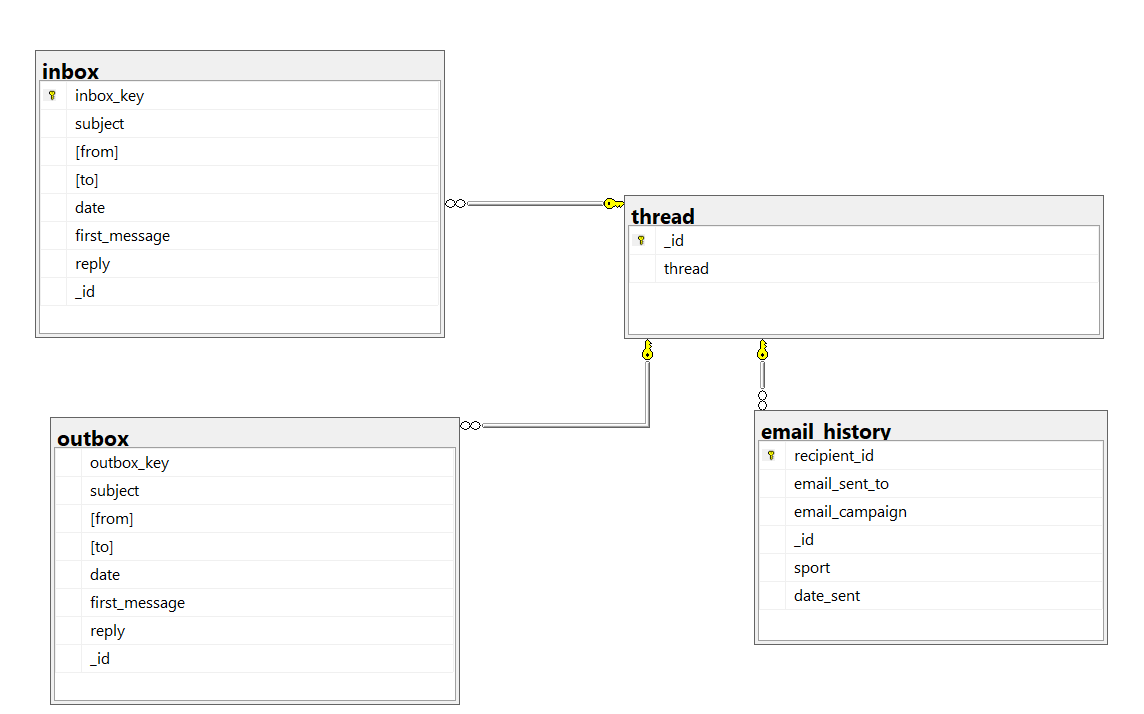